# INTRODUCTION, PROBLEM STATEMENT, and BUSINESS UNDERSTANDING

In [3]:
# import necessary libraries
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import string
import regex as re


from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk import word_tokenize
from nltk import FreqDist

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn import set_config

from PIL import Image
from wordcloud import WordCloud
from textwrap import wrap

import joblib

In [13]:
df = pd.read_csv(r'..\\data\\best_travel_destinations_for_2025.csv', encoding='latin1')
df

,Attraction,Description,Country,Continent
0,Amboseli National Park,Amboseli belongs in the elite of Kenyaâs nat...,Kenya,Africa
1,Fort Jesus,This 16th-century fort and Unesco World Herita...,Kenya,Africa
2,David Sheldrick Wildlife Trust,"Occupying a plot within Nairobi National Park,...",Kenya,Africa
3,Nairobi National Park,Welcome to Kenyaâs most accessible yet incon...,Kenya,Africa
4,National Museum,"Kenyaâs wonderful National Museum, housed in...",Kenya,Africa
...,...,...,...,...
18035,Byzantine Basilica,Near the Citadel's archaeological museum is th...,Jordan,Middle East
18036,Sharif Al Hussein Bin Ali Mosque,This grand and beautiful gleaming white mosque...,Jordan,Middle East
18037,North Theatre,The North Theatre is overgrown and missing muc...,Jordan,Middle East
18038,Shops,The shells of a row of shops remain in the wes...,Jordan,Middle East


### Data exploration & cleaning

In [14]:
df. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18040 entries, 0 to 18039
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attraction   18040 non-null  object
 1   Description  18040 non-null  object
 2   Country      18040 non-null  object
 3   Continent    18040 non-null  object
dtypes: object(4)
memory usage: 563.9+ KB


In [15]:
df.describe()

,Attraction,Description,Country,Continent
count,18040,18040,18040,18040
unique,17185,18024,25,7
top,Cathedral,Buddhist ruins in Si Satchanalai-Chaliang Hist...,China,Asia
freq,19,4,1200,4480


In [16]:
df. shape

(18040, 4)

In [8]:
# check for null values
# No null values because we scraped the data ourselves
df.isna().sum()

Attraction     0
Description    0
Country        0
Continent      0
dtype: int64

### Handle duplicates

In [17]:
# Check for duplicate rows
print(df.duplicated().sum())

9


In [18]:
all_duplicates = df[df.duplicated(keep=False)]
print(all_duplicates)

                                   Attraction  \
3439                              Yuexiu Park   
3440                              Yuexiu Park   
3479   Palace of Moon & Water Kwun Yum Temple   
3480   Palace of Moon & Water Kwun Yum Temple   
3639                       Rakadrak Hermitage   
3640                       Rakadrak Hermitage   
3679                          Huilan Pavilion   
3680                          Huilan Pavilion   
4999                         Pithoragarh Fort   
5000                         Pithoragarh Fort   
5157                    Himadri Hans Handloom   
5160                    Himadri Hans Handloom   
11559                             Kids Market   
11560                             Kids Market   
11637        Africville Heritage Trust Museum   
11641        Africville Heritage Trust Museum   
14359                       Cementerios 1 & 2   
14360                       Cementerios 1 & 2   

                                             Description Country  \


In [19]:
# Remove duplicates
df = df.drop_duplicates()

In [20]:
# Verify that duplicates are removed
print(df.duplicated().sum())

0


### Class imbalance

In [23]:
display(df.Country.unique())
print('Total Unique Countries:', len(df.Country.unique()))

array(['Kenya', 'South Africa', 'Egypt', 'Morocco', 'Japan', 'China',
       'India', 'Thailand', 'France', 'Italy', 'Germany', 'United States',
       'Canada', 'Mexico', 'Brazil', 'Argentina', 'Chile', 'Peru',
       'Australia', 'New Zealand', 'Fiji', 'United Arab Emirates',
       'Turkey', 'Israel', 'Jordan'], dtype=object)

Total Unique Countries: 25


In [25]:
df.Country.value_counts(normalize=True)

Japan                   0.066552
United States           0.066552
France                  0.066552
Italy                   0.066552
Germany                 0.066552
Australia               0.066552
India                   0.066441
Canada                  0.066441
China                   0.066330
Mexico                  0.059897
Turkey                  0.057678
Thailand                0.048805
South Africa            0.035494
Brazil                  0.033276
Egypt                   0.028839
New Zealand             0.022184
Morocco                 0.019966
Argentina               0.019966
Peru                    0.019966
Chile                   0.017692
Jordan                  0.008874
Kenya                   0.008874
Israel                  0.008874
United Arab Emirates    0.006655
Fiji                    0.004437
Name: Country, dtype: float64

In [26]:
countries = df.groupby('Country').count()

In [27]:
countries.reset_index(inplace=True)

In [28]:
sorted_countries = countries.sort_values(by='Attraction', ascending=False)
sorted_countries

,Country,Attraction,Description,Continent
12,Italy,1200,1200,1200
8,France,1200,1200,1200
13,Japan,1200,1200,1200
1,Australia,1200,1200,1200
9,Germany,1200,1200,1200
24,United States,1200,1200,1200
10,India,1198,1198,1198
3,Canada,1198,1198,1198
5,China,1196,1196,1196
16,Mexico,1080,1080,1080


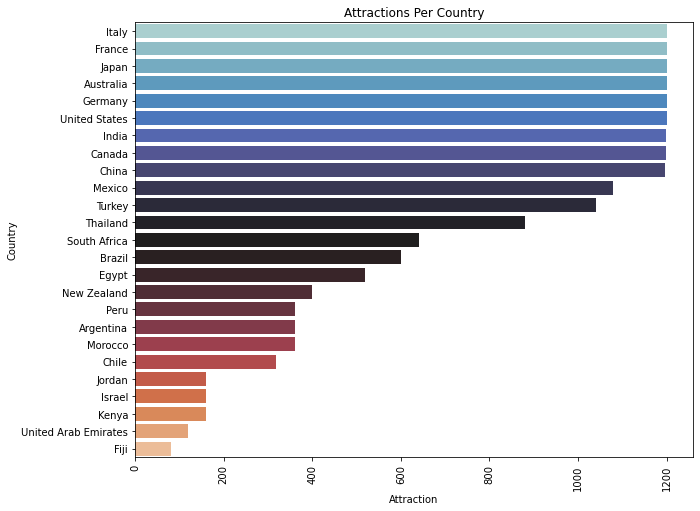

In [30]:
# Plot the class imbalance
plt.figure(figsize=(10,8))
sns.barplot(x='Attraction', y='Country', data=sorted_countries, palette='icefire')
plt.title('Attractions Per Country')
plt.xticks(rotation=90)
plt.show()